### Import dữ liệu và chuẩn hoá


In [4]:
import json
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Tải các gói cần thiết từ nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Khởi tạo công cụ chuẩn hoá
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hàm chuẩn hóa văn bản
def preprocess_text(text):
    text = text.lower() # Chuyển đổi về chữ thường
    text = ''.join([ch for ch in text if ch not in string.punctuation]) # Loại bỏ dấu câu
    tokens = text.split() # Tách từ
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Lematization và loại bỏ stop words
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import json

# Load file JSON
with open("students.json", "r", encoding="utf-8") as f:
    student_info = json.load(f)

with open("student_skills.json", "r", encoding="utf-8") as f:
    student_skills = json.load(f)

with open("lecturer_profiles_summarized.json", "r", encoding="utf-8") as f:
    lecturer_data = json.load(f)


In [7]:
# Tạo từ điển để tra nhanh kỹ năng
skill_map = {s["student_id"]: s["skills"] for s in student_skills}

# Kết hợp thông tin
students = []
for s in student_info:
    sid = s["id"]
    students.append({
        "id": sid,
        "name": s["name"],
        "faculty": s["khoa"],
        "skills": skill_map.get(sid, [])  # mặc định [] nếu không có
    })


In [8]:
# Xây văn bản đầu vào cho từng sinh viên
def build_student_text(student):
    combined_text = ' '.join(student.get("skills", []))
    return preprocess_text(combined_text)

student_corpus = [build_student_text(s) for s in students]

In [9]:
# Xây văn bản đầu vào cho từng giảng viên
def build_lecturer_text(lecturer):
    parts = []
    parts.extend(lecturer.get("keywords", []))
    parts.append(lecturer.get("expertise", ""))
    interests = lecturer.get("interests", [])
    for item in interests:
        if isinstance(item, dict):
            parts.append(item.get("group", ""))
            parts.extend(item.get("items", []))
        elif isinstance(item, str):
            parts.append(item)
    return preprocess_text(' '.join(parts))

lecturer_corpus = [build_lecturer_text(l) for l in lecturer_data]

## TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

vectorizer = TfidfVectorizer()

# Gộp cả 2 corpus để xây dựng cùng không gian vector
combined_corpus = student_corpus + lecturer_corpus
vectorizer.fit(combined_corpus)

student_matrix = vectorizer.transform(student_corpus)   
lecturer_matrix = vectorizer.transform(lecturer_corpus)  

# Chuyển student TF-IDF matrix thành DataFrame
student_df = pd.DataFrame(student_matrix.toarray(), columns=vectorizer.get_feature_names_out())
lecturer_df = pd.DataFrame(lecturer_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print("Student TF-IDF Matrix:")
print(student_df.head())
print("\nLecturer TF-IDF Matrix:")
print(lecturer_df.head())


Student TF-IDF Matrix:
   accuracy  addressing  affective   ai  algorithm  allocation  alongside  \
0  0.237492         0.0        0.0  0.0    0.00000         0.0        0.0   
1  0.000000         0.0        0.0  0.0    0.35334         0.0        0.0   
2  0.000000         0.0        0.0  0.0    0.00000         0.0        0.0   
3  0.000000         0.0        0.0  0.0    0.00000         0.0        0.0   
4  0.000000         0.0        0.0  0.0    0.00000         0.0        0.0   

   also  analysis  analytics  ...  truth  university     using  validation  \
0   0.0  0.115768        0.0  ...    0.0         0.0  0.141028    0.000000   
1   0.0  0.000000        0.0  ...    0.0         0.0  0.000000    0.000000   
2   0.0  0.000000        0.0  ...    0.0         0.0  0.308062    0.000000   
3   0.0  0.395300        0.0  ...    0.0         0.0  0.160518    0.229791   
4   0.0  0.395300        0.0  ...    0.0         0.0  0.160518    0.229791   

   vietnamese    vision  visualization  web  

## Cosine Similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Tính similarity cho từng sinh viên với toàn bộ giảng viên
similarity_matrix = cosine_similarity(student_matrix, lecturer_matrix)


In [13]:
raw_matching_results = []

for i, student in enumerate(students):
    sims = similarity_matrix[i]
    result = {
        "student_id": student["id"],
        "student_name": student["name"],
        "matches": []
    }
    for j, score in enumerate(sims):
        result["matches"].append({
            "lecturer_id": lecturer_data[j]["ID"],
            "lecturer_name": lecturer_data[j]["Lecturer"],
            "similarity": float(score)
        })
    raw_matching_results.append(result)

# Save raw results to file
raw_output_path = "raw_matching_results.json"
with open(raw_output_path, "w", encoding="utf-8") as f:
    json.dump(raw_matching_results, f, ensure_ascii=False, indent=2)


## Xác định threshold

In [19]:
import json
import pandas as pd

#Load dữ liệu JSON từ file
with open("raw_matching_results.json", "r", encoding="utf-8") as f:
    matches = json.load(f)

#Trích xuất các điểm similarity
rows = []
for item in matches:
    student_id = item["student_id"]
    student_name = item["student_name"]
    for match in item["matches"]:
        rows.append({
            "student_id": student_id,
            "student_name": student_name,
            "lecturer_id": match["lecturer_id"],
            "lecturer_name": match["lecturer_name"],
            "similarity_score": match["similarity"]
        })

df = pd.DataFrame(rows)

#Tính thống kê mô tả
summary = df["similarity_score"].describe()
q75 = df["similarity_score"].quantile(0.75)

print("Summary statistics of similarity scores:")
print(summary)
print(f"\n75th percentile (Q3): {q75:.4f}")


Summary statistics of similarity scores:
count    25.000000
mean      0.124418
std       0.085685
min       0.014926
25%       0.073810
50%       0.104966
75%       0.156831
max       0.326583
Name: similarity_score, dtype: float64

75th percentile (Q3): 0.1568


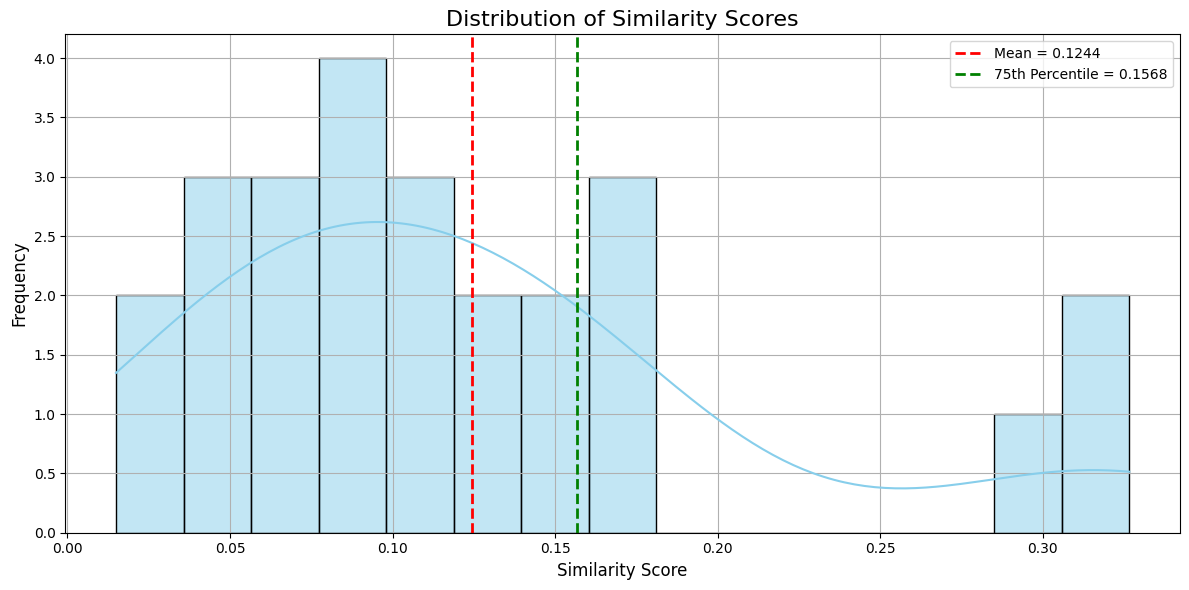

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Tính toán ngưỡng ===
mean_score = df["similarity_score"].mean()
q75 = df["similarity_score"].quantile(0.75)
plt.figure(figsize=(12, 6))
sns.histplot(df["similarity_score"], bins=15, kde=True, color="skyblue", edgecolor="black")

# Đường trung bình
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_score:.4f}')
# Đường Q3 (75th percentile)
plt.axvline(q75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile = {q75:.4f}')

# Tùy chỉnh biểu đồ
plt.title("Distribution of Similarity Scores", fontsize=16)
plt.xlabel("Similarity Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Chọn Threshold là Q3= 0.1568
Giải thích:
- Q3 nghĩa là điểm tương đồng nằm trong top 25% cao nhất toàn bộ phân phối.
- Trong biểu đồ, phần bên phải của đường xanh chứa các matching mạnh (có điểm similarity cao).
- Việc chọn Q3 giúp loại bỏ 75% matching yếu kém hoặc không rõ ràng.
- Dữ liệu có nhiều điểm similarity nhỏ nằm bên trái → kéo mean xuống (~0.12).
- Nếu chọn theo mean thì sẽ giữ lại cả những cặp có similarity ≈ 0.10–0.12 (chất lượng thấp hơn).
- Chọn Q3 đảm bảo chỉ giữ lại các matching tốt hơn trung bình rõ ràng.
- Nếu chọn quá cao như 90th percentile (~0.25), ta có thể bỏ sót nhiều matching tiềm năng.
- Nếu chọn thấp hơn (mean), thì bao gồm nhiều matching không đủ độ tin cậy.
- Q3 = 0.1568 là điểm cân bằng hợp lý giữa precision và recall.


## Ranking

In [21]:
import pandas as pd

threshold = q75
df_filtered = df[df["similarity_score"] >= threshold]

# Số lượng giảng viên tối đa muốn gợi ý cho mỗi sinh viên
top_k = 3

# Sắp xếp theo similarity giảm dần
df_sorted = df_filtered.sort_values(by=["student_id", "similarity_score"], ascending=[True, False])

# Lấy top K theo từng sinh viên
df_ranked = df_sorted.groupby("student_id").head(top_k).reset_index(drop=True)

# Hiển thị kết quả đầu ra
print("Top K recommendation per student:")
print(df_ranked.head())


Top K recommendation per student:
  student_id         student_name lecturer_id         lecturer_name  \
0   20521779  Trần Ngọc Mỹ Phương       GV005  Nguyễn Thị Kim Phụng   
1   20521779  Trần Ngọc Mỹ Phương       GV004      Trần Hưng Nghiệp   
2   20521779  Trần Ngọc Mỹ Phương       GV001     Nguyễn Đình Thuân   
3   20521825        Đoàn Tú Quỳnh       GV005  Nguyễn Thị Kim Phụng   
4   20521825        Đoàn Tú Quỳnh       GV004      Trần Hưng Nghiệp   

   similarity_score  
0          0.326583  
1          0.173380  
2          0.156831  
3          0.326583  
4          0.173380  


## Visualization


In [10]:
pip install streamlit

     ---------------------------------------- 0.0/44.3 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.3 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.3 kB 325.1 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.3 kB 325.1 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.3 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 44.3/44.3 kB 167.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.1 MB 991.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.1 MB 825.8 kB/s eta 0:00:13
   ---------------------------------------- 0.1/10.1 MB 825.8 kB/s eta 0:00:13
   ---------------------------------------- 0.1/10.1 MB 825.8 kB/s eta 0:00:13
   ---------------------------------------- 0.1/10.1 MB 374.1 kB/s eta 0:00:27
   ---------------------------------------- 0.1/10.1 MB 420.8 kB/s eta


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Windows\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ====== Input ======
student_id_input = "20521779"  # hoặc sử dụng input() nếu muốn nhập động
threshold = 0.1568
top_k = 3

# ====== Lọc dữ liệu theo MSSV ======
filtered_df = df[
    (df["student_id"].astype(str) == student_id_input) &
    (df["similarity_score"] >= threshold)
]

# Sắp xếp theo điểm similarity giảm dần và lấy top K
ranked_df = filtered_df.sort_values(by="similarity_score", ascending=False).head(top_k)


C:\Users\Windows\AppData\Local\Temp\ipykernel_1380\2937982190.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


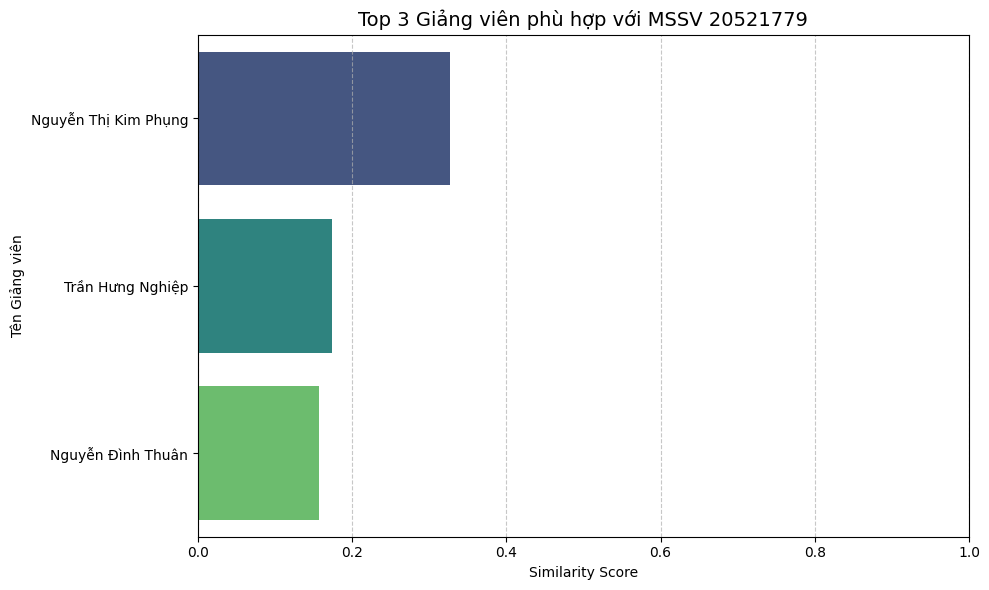

In [29]:
# ====== Vẽ bar chart ======
if ranked_df.empty:
    print(f"Không có giảng viên nào phù hợp với MSSV: {student_id_input}")
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=ranked_df,
        x="similarity_score",
        y="lecturer_name",
        palette="viridis"
    )

    plt.title(f"Top {top_k} Giảng viên phù hợp với MSSV {student_id_input}", fontsize=14)
    plt.xlabel("Similarity Score")
    plt.ylabel("Tên Giảng viên")
    plt.xlim(0, 1)  # vì cosine similarity nằm trong [0, 1]
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()